# <span style="color:green"> Run on python 3.6</span>

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

ПРОТЕСТИТЬ, ЧТОБЫ ОДИН ГПР ИЛИ ОДНА СЕТКА МОГЛИ ЗАФТИТИТЬ ЗАВИСИМОСТЬ ДЛЯ ОДНОЙ КОМПОНЕНТЫ

- Матрица X - это не вектора V, на которые мы проектируем силы, X должна быть ранга 1

In [1]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
import gc
import torchvision.transforms as transforms

from itertools import islice
from collections import defaultdict
import csv

from utility_funcs import *

- Проблема с двумя частицами в том, что у них абсолютно одинаковые матрицы X, но разные перемещения, но почему у них одинаковые матрицы......
- потестить если юзать только одну частицу для обучения

In [2]:
MODE

'movements'

In [3]:
naming_of_target_in_csv = naming_of_target_in_csv[MODE]

In [4]:
def create_movements_csv(N, step=1, coords_path_to_get_movements_from=None, convert_to_csv=True, create_d_velocity=False, path_to_get_velocities_from=None):
    '''
    N - number of particles in coordsN.csv file that will be used to calculate movements
    step - step for parsing rows of dataframe

    coords_path_to_get_movements_from if not passed, will be ./coords_and_forces/coords" + str(N)

    convert_to_csv: True by default, if False - will return dataframe object

    create_d_velocity: this function is also used to create d_velocities, if True - will create d_velocitiesN.csv

    path_to_get_velocities_from: default path for velocities, to sync rows we need to select rows with a step and drop last one and then save
    '''
    if coords_path_to_get_movements_from is None:
        coord_rows = pd.read_csv("./coords_and_forces/coords" + str(N) + ".csv")[::step]
    else:
        coord_rows = pd.read_csv(coords_path_to_get_movements_from)[::step]
    coord_rows[:-1].to_csv("./coords_and_movements/coords" + str(N) + ".csv", index=False)

    if path_to_get_velocities_from is None:
        vel_rows = pd.read_csv("./coords_and_forces/velocities" + str(N) + ".csv")[::step]
    else:
        vel_rows = pd.read_csv(path_to_get_velocities_from)[::step]
    vel_rows[:-1].to_csv("./coords_and_movements/velocities" + str(N) + ".csv", index=False)

    movements = defaultdict(list)

    naming = ["t"]
    for i in range(N):
        naming.extend([str(i) + "s_x", str(i) + "s_y", str(i) + "s_z"])
    
    for row_numb in range(len(coord_rows) - 1):
        cur_coords = coord_rows.iloc[row_numb].to_numpy()
        next_coords = coord_rows.iloc[row_numb + 1].to_numpy()
        delta = (next_coords - cur_coords)
        for i in range(len(naming)):
            movements[naming[i]].append(delta[i])


    if create_d_velocity:
        d_velocities = defaultdict(list)

        naming = ["t"]
        for i in range(N):
            naming.extend([str(i) + "dv_x", str(i) + "dv_y", str(i) + "dv_z"])
        
        for row_numb in range(len(vel_rows) - 1):
            cur_coords = vel_rows.iloc[row_numb].to_numpy()
            next_coords = vel_rows.iloc[row_numb + 1].to_numpy()
            delta = (next_coords - cur_coords)
            for i in range(len(naming)):
                d_velocities[naming[i]].append(delta[i])    

        d_velocities = pd.DataFrame(d_velocities)
        d_velocities.to_csv("./coords_and_movements/d_velocities" + str(N) + ".csv", index=False)
    
    movements = pd.DataFrame(movements)
    if convert_to_csv:
        movements.to_csv("./coords_and_movements/movements" + str(N) + ".csv", index=False)
    else:
        return movements

In [5]:
def print_normed(V: np.array) -> None:
    print(
        V / norm(V, axis=-1)[:, np.newaxis]
    )

In [6]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

---

# Hyperparameters:

In [7]:
f'p: {CFG.p}, r_cut: {CFG.r_cut}'

'p: [2.68815641 2.89909053 2.22408131], r_cut: [6.75646099 8.1485677  5.11401858]'

In [8]:
# CFG.p = np.array([1., 2., 3.])
# CFG.r_cut = np.array([3, 7, 10])

---

## Код для создания моих csv файлов из .xyz или .force

In [9]:
@njit
def _force(r):
    '''
    r is a vector from one particle to another
    '''
    d = norm(r)
    f = 4 * (12 * pow(d, -13) - 6 * pow(d, -7)) * (r / d)
    return f

calc_forces = np.vectorize(_force)

Используя np.reshape() можно 1d array превращать в матрицу просто

In [10]:
def get_rel_dists(row, atom_number, N):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''


    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    # print('rel_dists: ', Rel_matrix)

    return np.array(Rel_matrix)

# Короче надо как-то научиться создавать список, в котором каждые N * step шагов будут выкинуты N подряд идущих чисел - это сразу решит проблему обрезания по частицам и шага по состояниям

def generate_useful_indexes(N, step, length):
    '''
    Дает список из индексов для номеров строчек, которые надо использовать при большем цикле считывания
    '''
    sp = []
    for i in range(0, length, step * N):
        for j in range(0, N):
            sp.append(i + j)
    return sp

def get_rows_for_use_particles(old_N, new_N, length):
    '''
    Дает список из индексов для номеров строчек, которые надо использовать при уменьшении числа частиц
    '''
    sp = []
    for i in range(0, length, old_N):
        for j in range(0, new_N):
            sp.append(i + j)
    return sp

In [11]:
# NUMPY VERSION:

def create_csv_from_force(write_folder, read_path, recalculate_forces=False, normalize_forces=False, use_particles=None, step=1, lines_read_coef=None, velocity_regime=None):
    '''
    создает .csv формат из .force
    по-сути делает цсв-хи с которыми я работаю из LAMMPS-овского аутпута

    use_particles - количество частиц, которое использовать, то есть сколько из записанных координат использовать (это нормально реализовать супер геморрой)
    recalculate_forces - пересчитать силы
    normalize_forces - нормализовать силы

    step - шаг на количество позиций при чтении (оно в текущей версии очень долго работает с этим параметром)
    lines_read_coef - N * lines_read_coef строчек с координатами считывается - то есть lines_read_coed - количество конфигураций, которое считывается
    '''
    # через решейп к (lines_read, 3) - удаляем с шагом строчки: x = np.delete(x, np.arange(0, x.size, use_particles))

    if use_particles and not velocity_regime:
        recalculate_forces = True
        print("use_particles is not None - forces will be recalculated anyway")
    with open(read_path, 'r+') as f:
        for i in range(3):
            f.readline()

        N = int(str(f.readline()).strip())

    actual_steps = generate_useful_indexes(N, step, length=int(5e5))

    with open(read_path, 'r+') as read_f:
        all_forces = []
        all_coords = []
        lines_read = 0  # строчки с координатами прочитанные
        for line in (read_f):
            if line[0] == 'C':
                # if lines_read in actual_steps:
                    # if lines_read % (N * step) == 0:    # делаем шаг
                    arr = list(map(lambda x: float(x.strip()), line.split(' ')[1:]))
                    arr_coords = (arr[:3])
                    if not recalculate_forces:
                        arr_forces = (arr[3:])
                        all_forces.extend(arr_forces)
                    all_coords.extend(arr_coords)
                    lines_read += 1

            if lines_read_coef and lines_read >= lines_read_coef * N:
                break
    all_coords = np.reshape(all_coords, (lines_read // N, 3 * N))
    if not recalculate_forces:
        all_forces = np.reshape(all_forces, (lines_read // N, 3 * N))

    if use_particles is not None and use_particles < N:
        # Силы здесь не надо откидывать - если use_particles - их надо пересчитывать
        coords_single_vecs = np.reshape(all_coords, (lines_read, 3))
        length = len(coords_single_vecs)

        new_rows_idxs = get_rows_for_use_particles(old_N=N, new_N=use_particles, length=length)
        coords_single_vecs = coords_single_vecs[new_rows_idxs]

        new_lines_read = len(coords_single_vecs)
        all_coords = np.reshape(coords_single_vecs, (new_lines_read // use_particles, 3 * use_particles))
        N = use_particles
        lines_read = new_lines_read
        CFG.N = use_particles

    # CFG.N = N
    coords_path = write_folder + '/coords' + str(N) + '.csv'
    forces_path = write_folder + '/forces' + str(N) + '.csv'
    if velocity_regime:
        forces_path = write_folder + '/velocities' + str(N) + '.csv'

    fieldnames_forces = []
    fieldnames_coords = []
    for i in range(N):
        fieldnames_coords.extend([str(i) + 'x', str(i) + 'y', str(i) + 'z'])
        if not velocity_regime:
            fieldnames_forces.extend([str(i) + "f_x", str(i) + "f_y", str(i) + "f_z"])
        else:
            fieldnames_forces.extend([str(i) + "v_x", str(i) + "v_y", str(i) + "v_z"])

    if not velocity_regime:
        df_coords = pd.DataFrame(all_coords,
                    index=np.arange(len(all_coords)),
                    columns=fieldnames_coords)
        df_coords.index.name = 't'
        df_coords.to_csv(coords_path)

    if recalculate_forces and not velocity_regime:
        all_forces = []
        for index in tqdm(range(len(df_coords)), desc='Progress for rows: Forces recalculation:'):
            for atom_number in range(N):
                Rel_dists_mat = get_rel_dists(df_coords.loc[index], atom_number, N=N)
                f = np.sum(np.apply_along_axis(_force, -1, Rel_dists_mat), axis=0)
                
                all_forces.append(f)

        all_forces  = np.vstack(all_forces)
        all_forces = np.reshape(all_forces, (lines_read // N, 3 * N))        

    if MODE == "movements" and velocity_regime:
        all_forces = all_forces[:-1]    # потому что перемещения для всех строчек кроме последней определяются

    df_forces = pd.DataFrame(all_forces,
                index=np.arange(len(all_forces)),
                columns=fieldnames_forces)
    df_forces.index.name = 't'
    df_forces.to_csv(forces_path)

**Create csv_from_force - функция, которая создает цсв-хи с которыми я работаю из LAMMPS-овского аутпута**

In [12]:
read_path = f'high_T1_{CFG.N}particle.force'
lines_read_coef = 1500

# Создаем цсвшки для координат и силы:

create_csv_from_force(
    write_folder="coords_and_forces",

    # read_path='high_T.force',
    read_path=read_path,

    use_particles=2,

    recalculate_forces=True if MODE == "forces" else False,
    # step = 1,
    lines_read_coef=lines_read_coef,
)

use_particles is not None - forces will be recalculated anyway


Progress for rows: Forces recalculation:: 100%|██████████| 1500/1500 [00:04<00:00, 334.70it/s]


In [13]:
velocity_path = read_path.split(".")[0] + ".velocity" if MODE == "movements" else None

#Создаем цсвшки для скоростей:
if velocity_path:
    create_csv_from_force(
    write_folder="coords_and_forces",        # СОХРАНЯЕМ ЦСВШКУ ДЛЯ СКОРОСТЕЙ ИМЕННО К СИЛАМ, ПОТОМУ ЧТО МЫ ДОЛЖНЫ ДРОПНУТЬ ПОСЛЕДНЮЮ СТРОЧКУ И ЕЩЕ СДЕЛАТЬ STEP - ЭТО ДЕЛАЕТСЯ КАК РАЗ ВНУТРИ ФУНКЦИИ СОЗДАНИЯ MOVEMENTS.CSV

    # read_path='high_T.force',
    read_path=velocity_path,

    use_particles=CFG.N,
    recalculate_forces=False if MODE=="movements" else True,      # СУПЕР ВАЖНО - ПОТОМУ ЧТО СКОРОСТИ ТАМ КАК СИЛЫ ВОСПРИНИМАЮТСЯ В КОДЕ...,

    velocity_regime=True,
    # step = 1,
    lines_read_coef=lines_read_coef,
    )

---

In [14]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)
    forces = pd.read_csv(forces_file_path)

    # print(len(coords), len(forces))

    # print(
    #     pd.concat([coords, forces], axis=1).notna().sum()
    # )

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    # return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')
    # return coords.join(forces.set_index("t"), on="t")
    return pd.concat([coords, forces], axis=1)

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [15]:
def _get_relative_positions(row, atom_number, naming_of_target_in_csv=naming_of_target_in_csv):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in naming_of_target_in_csv:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    # print('rel_dists: ', Rel_matrix)

    return np.array(Rel_matrix), np.array(force_vec)

In [16]:
from sklearn.preprocessing import normalize

In [17]:
# @njit(fastmath=True)
def force(r):
    '''
    r is a vector from one particle to another
    '''
    d = norm(r)
    f = 4 * (12 * pow(d, -13) - 6 * pow(d, -7)) * (r / d)
    return f

# def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
#     '''
#     vec: np.array - normalized vector
#     norm: its norm
#     r_cut_i: i-th component of
#     '''
    
#     # return vec_norm * vec

#     # return 4 * (12 * pow(vec_norm, -13) - 6 * pow(vec_norm, -7)) * (vec)    # явный вид Леннард-Джонса
    
#     # return vec / vec_norm

#     return vec * np.exp(
#         -np.power((vec_norm / r_cut_i), p_i)
#         )
    
#     # return vec * (
#     #     -np.power((vec_norm / r_cut_i), p_i)        # Если вектора V_i близкие, то псевдообратная считается немного нестабильно
#     #     )

#     # return (pow(vec_norm, -r_cut_i) - pow(vec_norm, -p_i)) * (vec)    # Леннард-Джонс но степени - параметры

#     # Если мы хотим обучаться  на скоростях и на радиус-векторах, то можно взять - расстояние, на которое 

# make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [18]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K, use_orthogonal=False, use_A_t=True):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if use_orthogonal and CFG.K == 3:
        diagonal_V_matr = [[0] * CFG.K for i in range(K)]
        for i in range(K):
            diagonal_V_matr[i][i] = V[i][i]
        V = np.array(
            diagonal_V_matr
        )

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    # print(V, A)

    if use_A_t:
        X = V @ A.T
    else:
        X = V

    return X, A

In [19]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig, use_orthogonal=True, use_A_t=True, naming_of_target_in_csv=naming_of_target_in_csv):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number, naming_of_target_in_csv=naming_of_target_in_csv)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig, use_orthogonal=use_orthogonal, use_A_t=use_A_t)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [20]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold, f_min_threshold=CFG.f_min_threshold,
            naming_of_target_in_csv=naming_of_target_in_csv):
    '''

    Убирает строчки с аномально большими силами из df

    Также убирает нижни силы, меньше f_min_threshold

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in naming_of_target_in_csv:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) < f_min_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [21]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.pinv(A)

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_path = 'coords.csv', forces_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    clean=True,
    use_orthogonal=False,
    use_A_t=True,
    path_to_vel=None,
    
    use_vel=True,
    
    naming_of_target_in_csv=naming_of_target_in_csv
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    use_A_t: Использовать ли X = VA^T или X=V (при k!= 3 матрица будет не квадратной)

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_path, forces_file_path=forces_path)
    if length:
        df = df.loc[range(length)]

    # чистка df от больших сил
    if clean:
        df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    if MODE == "movements" and use_vel:
        if path_to_vel:
            df_vels = pd.read_csv(path_to_vel, index_col=False)
        else:
            df_vels = pd.read_csv("./coords_and_movements/" + f'velocities{CFG.N}.csv', index_col=False)

    row_indexes = [idx for i, idx in enumerate(df.index) if i % step == 0]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number, use_orthogonal=use_orthogonal, use_A_t=use_A_t, naming_of_target_in_csv=naming_of_target_in_csv)
            if transform:
                x = transform(x)
            else:
                x = torch.tensor(x)
            x = x.to(torch.float)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)
            flat_x = torch.flatten(x)

            if MODE == "movements" and use_vel:
                row_vels = df_vels.iloc[index]
                columns_to_get_vels_from = [str(atom_number) + elem for elem in ["v_x", "v_y", "v_z"]]
                vel_vec = torch.tensor(row_vels[columns_to_get_vels_from])
                flat_x = torch.cat([flat_x, vel_vec])

            dataset.append(
                (flat_x.to(torch.float), torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [22]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

class my_normalizer():
    def __init__(self, mean, std) -> None:
        self.mean = mean
        self.std = std
    
    def __call__(self, x):
        return (x - self.mean) / self.std

# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 1.1201671361923218
std = 0.3449265956878662

In [23]:
folder = "coords_and_" + MODE   # MODE справа

coords_file_path = folder + '/coords' + str(CFG.N) + '.csv'
forces_file_path = folder + '/' + MODE + str(CFG.N) + '.csv'    # и здесь тоже MODE вместо forces
velocities_file_path = folder + '/' + 'velocities' + str(CFG.N) + '.csv'
d_velocities_file_path = folder + '/' + 'd_velocities' + str(CFG.N) + '.csv'

In [24]:
coords_file_path

'coords_and_movements/coords2.csv'

**В файлах которые я пилю руками на своем коде - там запись в файлы не с начала движения может быть**

In [25]:
movements_step = 1

# movements.csv are created based on coords.csv in forces and then coords.csv gets cut and saved in movements folder and we get syncronized by amount of rows csv files

# So create movements.csv now does not cut velocity.csv
if MODE == "movements":
    create_movements_csv(
        #TODO: make create_movements.csv also cut default velocity file and save its cut version into movements folder
        CFG.N,
        step=movements_step,

        coords_path_to_get_movements_from=f'./LJ_modeling_realization/coords{CFG.N}.csv',
        path_to_get_velocities_from=f'./LJ_modeling_realization/velocities{CFG.N}.csv',

        create_d_velocity=True
    )

In [26]:
dataset_step = 1

dataset = create_tensor_dataset(
    coords_path=coords_file_path,
    forces_path=forces_file_path,

    path_to_vel=velocities_file_path,
    # use_vel=False,

    step=dataset_step,

    clean=False,
    use_orthogonal=True,     # оно может сработать только для K=3, так как матрица V размера K x 3

    use_A_t=True
    # use_A_t=False
)

Progress for atom 1: 100%|██████████| 949/949 [00:02<00:00, 450.29it/s]


In [27]:
dataset_folder = "dataset_objects/" + MODE + '/'
torch.save(dataset, dataset_folder + str(CFG.N) + '_dataset_K_' + str(CFG.K) + '.pt')

**Распределение для первого элемента матрицы:**

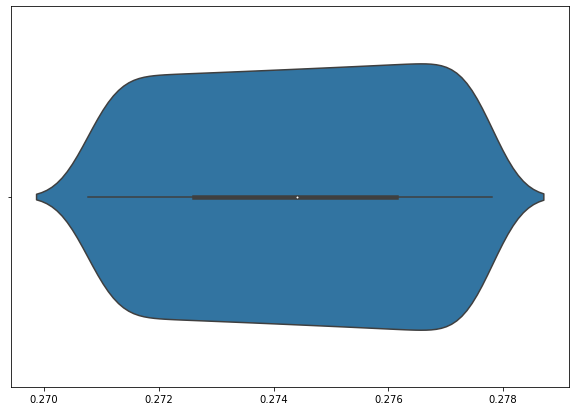

In [28]:
plt.figure(figsize=(10, 7))
sns.violinplot(
    x=[elem[0][0].item() for elem in dataset], width=0.7
)
None

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
dataset1 = dataset.copy()

In [31]:
# dataset = dataset1[:1000]

**Отрисовать Верле и отрисовать само трушное:**

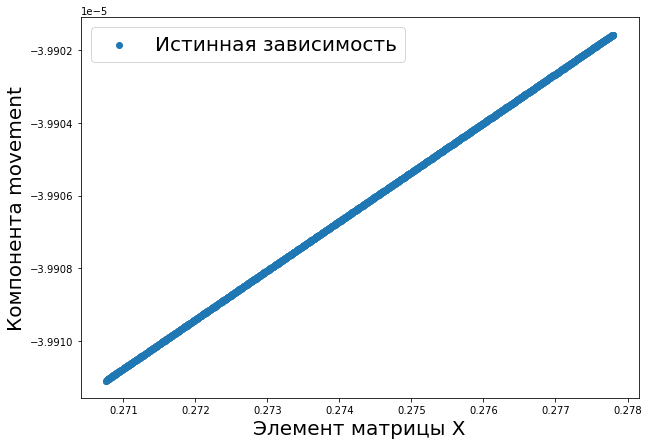

In [32]:
X = (torch.stack([elem[0] for elem in dataset]))
x11 = X[:, 0]
x22 = X[:, 4]
x33 = X[:, 8]

Y_true = torch.stack([elem[1] for elem in dataset])

plot_2d_result(
    x11,
    y_true=Y_true if len(dataset[0][1]) == 1 else Y_true[:, 0],
    figsize=(10, 7)
)

$$
X = V A^T
$$
Если все элементы матрицы V одинаковые, то матрица A имеет вид

**У нас все-таки перемещения и у них проекции не равны будут в векторе перемещений даже если все V_i совпадают**

In [33]:
dataset[:2]

[(tensor([ 0.2778,  0.0000,  0.0000,  0.0000,  0.6005,  0.0000,  0.0000,  0.0000,
           0.4176, -0.3990,  0.2977,  0.2273]),
  tensor([-3.9902e-05, -2.9772e-05, -2.2727e-05]),
  tensor([[ 1.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0., -1.]]),
  tensor([-3.9902e-05,  2.9772e-05,  2.2727e-05])),
 (tensor([ 0.2778,  0.0000,  0.0000,  0.0000,  0.6005,  0.0000,  0.0000,  0.0000,
           0.4176, -0.3990,  0.2977,  0.2273]),
  tensor([-3.9902e-05, -2.9772e-05, -2.2727e-05]),
  tensor([[ 1.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0., -1.]]),
  tensor([-3.9902e-05,  2.9772e-05,  2.2727e-05]))]

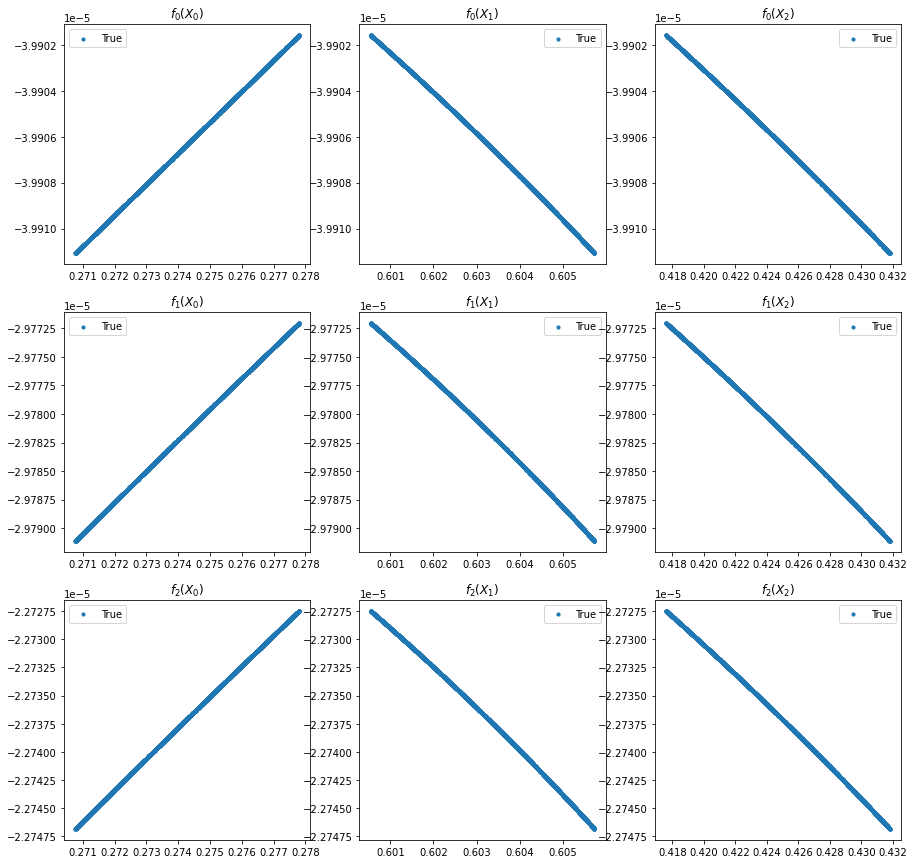

In [34]:
plot_matrix(X=X[:, :CFG.K * CFG.K], Y_true=Y_true, K=CFG.K)

Виды изменения матрицы X:

- K=3:
    - делать матрицу V вида: diag(V[0][0], V[1][1], V2][2]); позволяет избежать близости векторов внутри V за счет чего получаем более далекие значения а еще матрица pinv_a тогда не сингулярная - теряется симметрия относительно вращений (а может и нет кстати)

    - делать X = V вместо AV^T - так мы обучаемся прямо на модельных "силах" и знак так не съедается (мб стоит попробовать sgn добавить чтобы знак не хавался) - теряется симметрия относительно вращений

# Для модели для предсказания скоростей по тем же фичам:

In [35]:
def create_dataset_object_for_d_velocities(step=dataset_step, coords_path=coords_file_path, velocities_path=velocities_file_path, d_velocities_path=d_velocities_file_path):
    '''
    creates.pt for velocities: it will be a dataset object, which will be the same dataset as for movements/forces, but with dv instead of ds or f
    '''

    dataset = create_tensor_dataset(
        step=step,

        coords_path=coords_path,
        forces_path=d_velocities_path,

        path_to_vel=velocities_path,
        # use_vel=False,

        clean=False,
        use_orthogonal=True,     # оно может сработать только для K=3, так как матрица V размера K x 3

        use_A_t=True,

        naming_of_target_in_csv=["dv_x", "dv_y", "dv_z"]
        # use_A_t=False
    )
    dataset_folder = "dataset_objects/" + "d_velocities" + '/'
    torch.save(dataset, dataset_folder + str(CFG.N) + '_dataset_K_' + str(CFG.K) + '.pt')

    return dataset

Делаем так: При создании movements у нас создаются файлы для скоростей и для координат внутри coords_and_movements

In [36]:
vel_dataset = create_dataset_object_for_d_velocities()
None

Progress for atom 1: 100%|██████████| 949/949 [00:02<00:00, 416.84it/s]


In [37]:
vel_dataset[0]

(tensor([ 0.2778,  0.0000,  0.0000,  0.0000,  0.6005,  0.0000,  0.0000,  0.0000,
          0.4176, -0.3990,  0.2977,  0.2273]),
 tensor([-9.3378e-08, -1.8383e-07, -1.8598e-07]),
 tensor([[ 1.,  0.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0., -1.]]),
 tensor([-9.3378e-08,  1.8383e-07,  1.8598e-07]))

In [38]:
raise Exception("STOPPED")

Exception: STOPPED

---
---
---

---
---
---

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[1][0].size(), train_data[1][0]

(torch.Size([9]),
 tensor([0.0443, 0.0000, 0.0000, 0.0000, 0.1149, 0.0000, 0.0000, 0.0000, 0.2771]))

In [ ]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 0.043820273131132126, std = 0.07915274798870087


In [ ]:
# Проверка того, что при домножении на псведообратную матрицу получаем нужный вектор силы
t = dataset[0]
pinvA = t[2]
f = t[1]
F_3d = t[3]

F_3d, pinvA @ f

(tensor([ 0.2358, -0.1750, -0.0195]), tensor([ 0.2358, -0.1750, -0.0195]))

Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

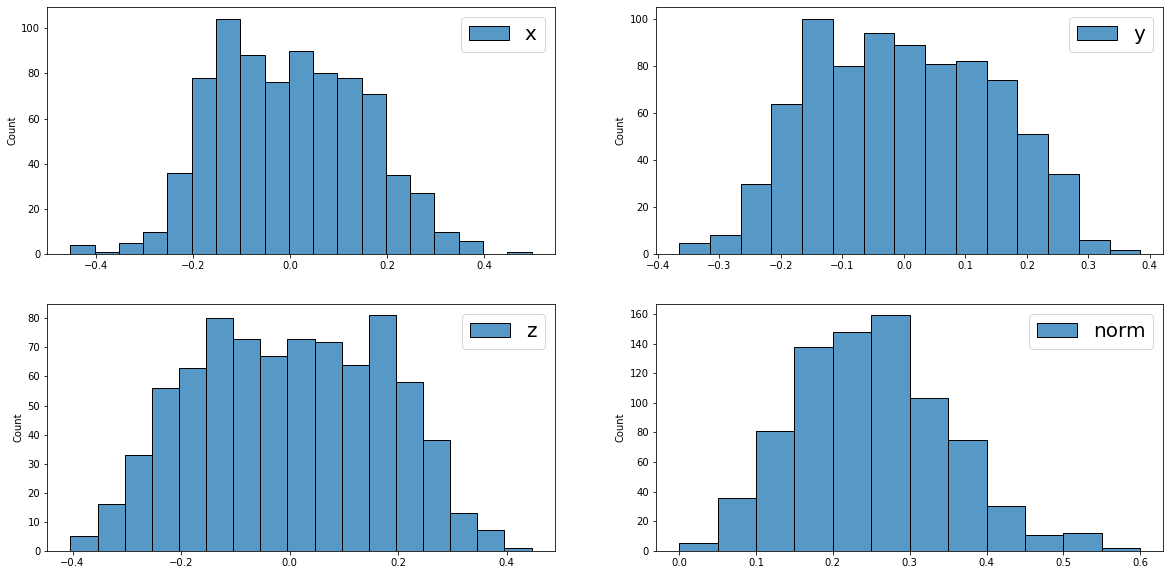

In [ ]:
def plot_target_distribution(data=dataset, figsize=(30, 20), fontsize=20):
    '''
    data: data in 
    '''
    target_3D = torch.stack([elem[3] for elem in data])
    x, y, z = list(map(lambda x: torch.stack(x), list(zip(*list(target_3D)))))
    target_3D = np.array(target_3D)
    target_norm = norm(target_3D, axis=-1)
    data = {'x': x, 'y': y, 'z': z, 'norm': target_norm}

    plt.figure(figsize=figsize)

    for (i, key) in enumerate(data):
        plt.subplot(2, 2, i + 1)
        ax = plt.gca()
        sns.histplot(data[key], label=f'{key}', stat='count', binwidth=0.05, ax=ax)
        plt.legend(loc='best', fontsize=fontsize)
    
    plt.show()


plot_target_distribution(figsize=(20, 10))

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

## Когда молекул уже будет много как хранить данные:

In [ ]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [ ]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [ ]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [ ]:
# next(iter(train_loader))[0]  # [batch_of_flattened_X, batch_of_k_dim_f, batch_of_pinv_a, batch_of_3d_f]

---

# Обучение:

## 1)Многомерный аутпут:

In [ ]:
import torch.nn.functional as F
import torch.cuda.amp as amp

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [ ]:
class MultiOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultiOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

        return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [ ]:
class GaussianNLLLossWithReadyVar(nn.GaussianNLLLoss):
    '''

    Custom GaussianNLLLoss that does not require passing var into forward

    The targets are treated as samples from Gaussian distributions, so var is calculated on full train data, assuming it was taken from the same distribution

    '''
    def __init__(self, full=False, eps=1e-06, reduction='sum'):
        super().__init__(full=full, eps=eps, reduction=reduction)
        self.__var_vector = torch.std(torch.stack([elem[1] for elem in train_data]), dim=0)
        # self.__var = torch.ones(200, 10, requires_grad=True)
        self.reduction = reduction

    def forward(self, input, target):
        # неважно, что оно может делать mean еще по размерностям, это всего лишь домножение на константу
        var = torch.stack([self.__var_vector] * input.size(0)).to(CFG.device)

        return F.gaussian_nll_loss(input=input, target=target, var=var, reduction=self.reduction) / input.size(0)

In [ ]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 8),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(8),

            nn.Linear(8, 32),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - это батч векторов т.ч.: size: [KxK], сам батч: (bath_size, KxK)

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [ ]:
def plot_k_dim_f_norm_from_x_norm(data_sample, figsize=(15, 10), fontsize=18):
    '''

    Функция строит зависимость таргета от X

    data_sample - итерируемый объект из тьюплов вида: (x, f_k_dim, f_3d, pinv_A)

    '''
    plt.figure(figsize=figsize)
    x = torch.stack([elem[0][0].squeeze() for elem in data_sample])

    y = torch.stack([elem[1][0].squeeze() for elem in data_sample])

    plt.scatter(x, y, label='y(x)')
    plt.title('Зависимость $Y_{target}(X)$', fontsize=fontsize)
    None

if CFG.K == 1:
    plot_k_dim_f_norm_from_x_norm(dataset)

#### Функции уже для обучения:

В качестве метрики буду использовать сумму MSE по компонентам, лоссы можно разные пробовать

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None, scaler=amp.GradScaler()):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim, A_pinv, F_3D)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device).detach()   # здесь можно не делать detach и обучать матрицу A

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()
        processed_data += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

/Users/avarlamov/opt/anaconda3/envs/my_3_6_conda_env/lib/python3.6/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs, 2)).to(CFG.device) 
        outputs_3D = torch.squeeze(outputs_3D, -1)

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum')
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size

    print(inputs.size(), outputs.size())

    return val_loss, val_MSE

In [ ]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=MultiOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
    return history

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict

In [ ]:
# model = SingleNet(
#     output_size=CFG.output_size,

#     # activation=nn.Tanh(),
#     activation=nn.ReLU(),

# ).to(CFG.device)

model = nn.Sequential(
    nn.Linear(CFG.K ** 2, 8),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(8),

    nn.Linear(8, 256),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(256),

    nn.Linear(256, 512),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.BatchNorm1d(512),

    nn.Linear(512, CFG.K)
)

optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=8, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=256, out_features=512, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=512, out_features=3, bias=True)
)

In [ ]:
history = train(
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    
    # scheduler=exp_scheduler,

    scaler=None,

    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    # criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    
    epochs=2
)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]/Users/avarlamov/opt/anaconda3/envs/my_3_6_conda_env/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
epoch: 100%|██████████| 2/2 [00:00<00:00, 16.17it/s]

torch.Size([8, 9]) torch.Size([8, 3])

Epoch 001 train_loss: 0.3588 val_loss 0.0425 train_MSE 0.3588 val_MSE 0.0425
torch.Size([8, 9]) torch.Size([8, 3])

Epoch 002 train_loss: 0.1382 val_loss 0.0285 train_MSE 0.1382 val_MSE 0.0285


In [ ]:
def make_predictions_and_plot(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=MultiOutputMSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''
    
    if CFG.K != 1:
        return

    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices).detach().numpy()
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    # metric = criterion(Y_pred, Y_target)
    
    plt.figure(figsize=figsize)
    fig = plt.gcf()
    # fig.suptitle(f'Metric: {metric}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)

        plt.scatter(X_matrices, Ys[i].squeeze(), label=f'Y(X) {name}')

        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

In [ ]:
if CFG.K == 1:
    make_predictions_and_plot(model=model, data=train_data, same_axis=True)

In [ ]:
def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    names = ['Losses', 'Metrics']
    
    figure = plt.figure(figsize=figsize)

    train_loss, train_metric, val_loss, val_metric = list(zip(*history))

    parameters = {'Losses': [train_loss, val_loss], 'Metrics': [train_metric, val_metric]}

    for i, name in enumerate(names):

        plt.subplot(1, 2, i + 1)
        plt.plot(range(1, len(history) + 1), parameters[name][0], label='train_loss')
        plt.plot(range(1, len(history) + 1), parameters[name][1], label='val_loss')
        
        plt.title(names[i], fontsize=18)
        plt.xlabel('epoch', fontsize=16)
        plt.ylabel('value', fontsize=16)     
        plt.xticks(np.arange(1, len(history) + 1, 1))
        # plt.yticks(np.arange(1, len(history) + 1, 1))
        plt.legend(loc='best', fontsize=16)
        plt.grid(alpha=0.4)
    
    plt.show()

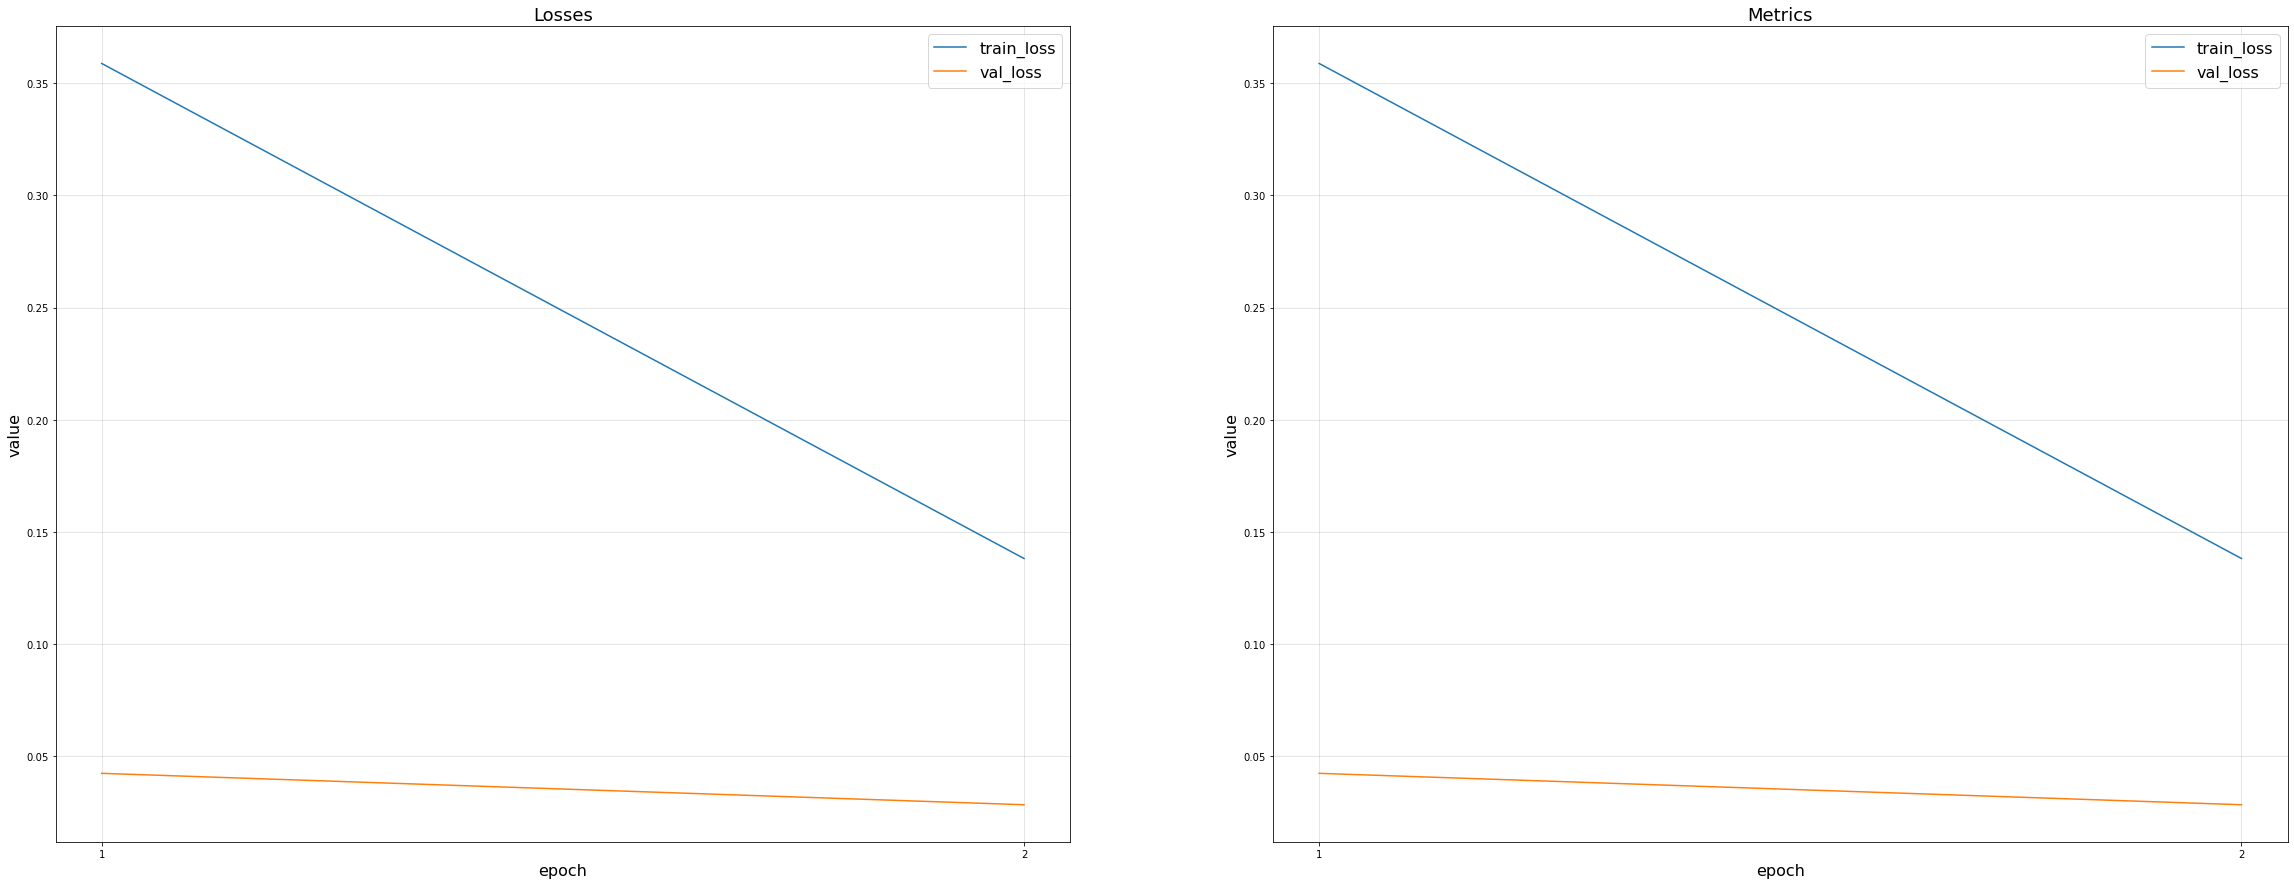

In [ ]:
plot_history(history=history)

---

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)
        - стоить понимать, что при количестве точек < 10 000 на гпу медленнее обучать (раз в 10)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [ ]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

In [ ]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [ ]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

cut_constant = 50

train_X = (torch.stack([elem[0] for elem in train_data[:cut_constant]]))
train_Y = torch.stack([elem[1] for elem in train_data[:cut_constant]])

val_X = (torch.stack([elem[0] for elem in val_data[:cut_constant]]))
val_Y = torch.stack([elem[1] for elem in val_data[:cut_constant]])

val_Y_3D = torch.stack([elem[3] for elem in val_data[:cut_constant]])
val_Y_pinv_As = torch.stack([elem[2] for elem in val_data[:cut_constant]])

# Тут в любом случае надо выпрямлять, потому что там проблемы с размерностями внутри gpytorch, если какое матричное ядро имплементить, то лучше будет просто внутри функции обратно на матрицы перейти и уже на них считать число

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [ ]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=CFG.K, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [ ]:
class MinusLogLikelihoodLoss:
    '''

    Object for computing NLLLoss

    '''
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [ ]:
class GPRMSELoss:
    '''
    
    object for calculation of MSE loss

    '''
    def __init__(self, likelihood):
        self.vanilla_MSE = MultiOutputMSELoss()
        self.likelihood = likelihood    # самописанные объекты изменяемые, поэтому этот имеет тот же id, что и глобальный likelihood

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object

        '''
        print(id(self.likelihood))
        mean_of_output = self.likelihood(model_output).mean

        return self.vanilla_MSE(mean_of_output, true_target)

In [ ]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history: dict: {'loss': [losses], 'MSE': [MSEs]}

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())
        # history['sigma'].append((lower, upper))

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [ ]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y, val_Y_pinv_As, val_Y_3D):
    '''
    
    One go dataset evaluation function

    Returns: mean, mean_3D, lower, upper

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        # output = model(val_X)
        # loss = loss_obj(output, val_Y)
        predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    mean_3D = torch.bmm(val_Y_pinv_As, torch.unsqueeze(mean.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
    mean_3D = torch.squeeze(mean_3D, -1)

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='sum').item() / mean.size(0)
    val_MSE_for_3D = F.mse_loss(input=mean_3D, target=val_Y_3D, reduction='sum').item() / mean_3D.size(0)

    # print(mean)

    print(f'val_MSE = {val_MSE}, val_MSE_for_3D = {val_MSE_for_3D}, val_RMSE_for_3D = {np.sqrt(val_MSE_for_3D)}')

    return mean, mean_3D, lower, upper

In [ ]:
class FeatureExtractor(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, extracted_size=CFG.K * CFG.K):
        super().__init__()

        # self.FC = nn.Sequential(
        #     nn.Linear(CFG.K * CFG.K, 1024),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     # nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, extracted_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(CFG.K * CFG.K, 128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, extracted_size)
        )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):

        x = self.FC(x)

        return x

In [ ]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=CFG.output_size)
feat_extractor = FeatureExtractor(extracted_size=32)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    # feature_extractor=feat_extractor
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)

NLL_loss = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)
MSE_loss = GPRMSELoss(likelihood=likelihood)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

**Одно и то же значение для mean выводится в состоянии model.train(), потому что мы выбрали ConstMean и это типо и есть наше среднее, которое мы вычисляем по трейновому датасету**

In [ ]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    
    loss_obj=NLL_loss,

    training_iterations=35,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.1750028133392334
Iter: 6, train_MSE = TODO, train_loss = 0.9930670261383057
Iter: 11, train_MSE = TODO, train_loss = 0.8539432883262634
Iter: 16, train_MSE = TODO, train_loss = 0.7662761211395264
Iter: 21, train_MSE = TODO, train_loss = 0.7480253577232361
Iter: 26, train_MSE = TODO, train_loss = 0.7339661717414856
Iter: 31, train_MSE = TODO, train_loss = 0.7312160134315491


одинаковые аутпуты в eval будут, если у нас очень резко сетка становится широкой из низкоразмерных данных, если мы используем feature_extractor, то есть та же проблема, что была с сетками просто

In [ ]:
mean, mean_3D, lower, upper = GP_eval(

    likelihood=likelihood,
    model=model,

    optimizer=optimizer,
    loss_obj=NLL_loss,

    val_X=val_X,
    val_Y=val_Y,

    val_Y_pinv_As=val_Y_pinv_As,
    val_Y_3D=val_Y_3D
)

val_MSE = 0.0014121727645397186, val_MSE_for_3D = 0.0014121727645397186, val_RMSE_for_3D = 0.03757888721795416


In [ ]:
def make_predictions_and_plot_GPR(model, likelihood, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''

    if CFG.K != 1:
        return
        
    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        X_matrices = X_matrices.squeeze().detach()
        Y_target = Y_target.squeeze().detach()

    prediction_distr = likelihood(model(X_matrices))
    lower, upper = prediction_distr.confidence_region()
    Y_pred = prediction_distr.mean.squeeze().detach()
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]

    plt.figure(figsize=figsize)
    fig = plt.gcf()
    fig.suptitle(f'{criterion._get_name()}: {criterion(Y_pred, Y_target)}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)
        plt.scatter(X_matrices, Ys[i].squeeze(), label=f'Y(X) {name}')

        plt.xlabel(f'X', fontsize=18)
        plt.ylabel(f'Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

In [ ]:
make_predictions_and_plot_GPR(model=model, likelihood=likelihood, data=val_data, same_axis=True)

## 3.2) Stochastic Variational GP Regression (обучение GPR по мини батчам):

---

# Пока мои выводы / результаты: 

Update:

удаляю совсем маленькие силы из датасета - GPR стал обучаться совсем идеально, а вот сетка совсем нет...